In [1]:
import mlflow
import os
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient

In [2]:
os.listdir("data/raw")

['green_tripdata_2021-01.parquet',
 'green_tripdata_2021-02.parquet',
 'green_tripdata_2021-03.parquet']

# Q1. Install MLflow

In [3]:
Q1 = "1.26.0"
print(f"mlflow, version {Q1}")

mlflow, version 1.26.0


# Q2. Download and preprocess the data

In [11]:
!python preprocess_data.py --raw_data_path "data/raw" --dest_path "data/preprocessed"

In [4]:
print(os.listdir("data/preprocessed"))
Q2 = len(os.listdir("data/preprocessed"))

['dv.pkl', 'test.pkl', 'train.pkl', 'valid.pkl']


# Q3. Train a model with autolog

In [12]:
!python train.py --data_path "data/preprocessed"

2022/05/26 13:19:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\PythonProjects\mlops-course\venv\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first."
2022/05/26 13:19:56 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


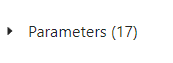

In [5]:
Q3 = 17
print("Autolog parameters", Q3)

Autolog parameters 17


# Q4. Launch the tracking server locally

In [13]:
"mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root artifacts"
Q4 = "default-artifact-root"
print("CLI argument for specifying artifacts folder: ", Q4)

CLI argument for specifying artifacts folder:  default-artifact-root


# Q5. Tune the hyperparameters of the model

In [48]:
!python hpo.py --data_path "data/preprocessed"


100%|██████████| 50/50 [05:24<00:00,  6.50s/trial, best loss: 6.6284257482044735]


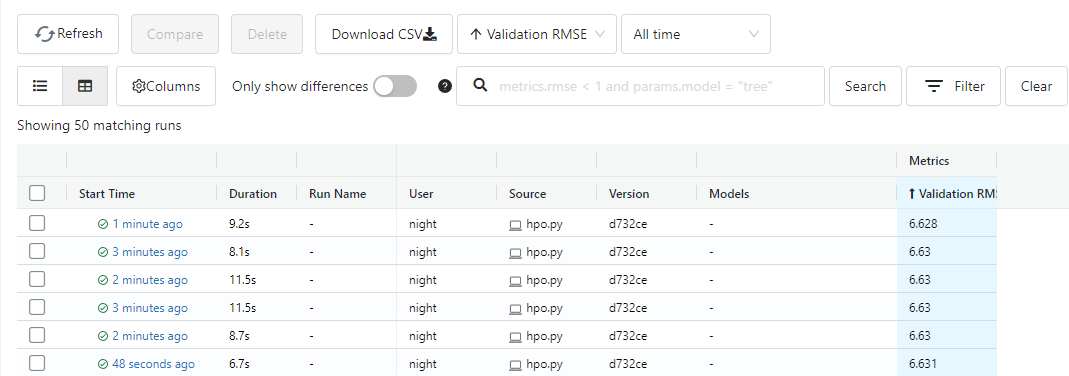

In [37]:
HPO_EXPERIMENT_NAME = "random-forest-hyperopt"
EXPERIMENT_NAME = "random-forest-best-models"

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment(EXPERIMENT_NAME)
experiment = client.get_experiment_by_name(HPO_EXPERIMENT_NAME)

client = MlflowClient()
runs = client.search_runs(
    experiment_ids=experiment.experiment_id,
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.Validation_RMSE ASC"]
)

Q5 = runs[0].data.metrics["Validation_RMSE"]
print("Minimal Validation loss is", Q5)

Minimal Validation loss is 6.6284257482044735


# Q6. Promote the best model to the model registry

In [49]:
!python register_model.py --data_path "data/preprocessed"

2022/05/26 16:30:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\PythonProjects\mlops-course\venv\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first."
Registered model 'random-forest-reg' already exists. Creating a new version of this model...
2022/05/26 16:31:15 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: random-forest-reg, version 2
Created version '2' of model 'random-forest-reg'.


In [54]:
last_experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
best_run = client.search_runs(
    experiment_ids=last_experiment.experiment_id,
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.Test_RMSE ASC"]
)[0]
Q6 = best_run.data.metrics["Test_RMSE"]
print("Test RMSE", Q6)

Test RMSE 6.547886185595423


In [55]:
print("Results:")
print("Q1", Q1)
print("Q2", Q2)
print("Q3", Q3)
print("Q4", Q4)
print("Q5", Q5)
print("Q6", Q6)

Results:
Q1 1.26.0
Q2 4
Q3 17
Q4 default-artifact-root
Q5 6.6284257482044735
Q6 6.547886185595423
